 # Assignment 1

 Daniel Cárdenas<br>
 FIN6326<br>
 `6102358`

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danielcs88/dupont_analysis/blob/master/dupont_analysis_assignment.ipynb)

In [1]:
# !pip install binarytree


In [2]:
import re
from typing import Union

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sqlalchemy import create_engine


In [3]:
plt.rcParams["figure.dpi"] = 125
get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'retina'")



In [4]:
def sql_query(query: str) -> pd.DataFrame:
    """
    Helper function to run SQL queries on in-house Pandas DataFrames

    Parameters
    ----------
    query : str
        SQL query to run
    Returns
    -------
    pd.DataFrame
        DataFrame of results
    """
    REGEX = r"(FROM )(\w+)"
    DF_NAME = re.search(REGEX, query)[2]
    DF = eval(DF_NAME)
    engine = create_engine("sqlite://", echo=False)
    DF.to_sql(DF_NAME, con=engine)
    RESULT = pd.DataFrame(engine.execute(query).fetchall())

    return RESULT


dollar_value = lambda x: f"${x:,.2f}"
rate_value = lambda x: f"{x:.2%}"



In [1]:
r_james = pd.read_csv(
    "https://raw.githubusercontent.com/danielcs88/dupont_analysis/master/Call_Cert33893_123121.SDF",
    sep=";",
)
b_united = pd.read_csv(
    "https://raw.githubusercontent.com/danielcs88/dupont_analysis/master/Call_Cert58979_123121.SDF",
    sep=";",
)

In [6]:
def financial_query(df: str, measure: str, measure_float=True) -> Union[float, str]:
    """
    Returns values from queried measure and specified bank DataFrame

    Parameters
    ----------
    df : str
        Name of bank pd.DataFrame which will be eval'ed
    measure : str
        Measure to be sought
    measure_float : TYPE, optional
        Return float result?. The default is True.

    Returns
    -------
    Union[float, str]
        DESCRIPTION.

    """

    if measure_float:
        return float(
            sql_query(f"SELECT * FROM {df} WHERE `Short Definition` LIKE '{measure}%'")[
                "Value"
            ].unique()[0]
        )
    else:
        return sql_query(
            f"SELECT * FROM {df} WHERE `Short Definition` LIKE '{measure}%'"
        )["Value"].iloc[0]



In [7]:
def roe(bank: str) -> float:
    """
    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Return on Equity.
    """
    return financial_query(bank, "Net income") / financial_query(bank, "Total equity")



In [8]:
def roa(bank: str) -> float:
    """
    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Return on Assets.

    """
    return financial_query(bank, "Net income") / financial_query(
        bank, "Total balance sheet assets"
    )



In [9]:
def equity_multiplier(bank: str) -> float:
    """
    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Equity Multiplier.

    """
    return financial_query(bank, "Total balance sheet assets") / financial_query(
        bank, "Total equity"
    )



In [10]:
def operating_income(bank: str) -> float:
    """
    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Operating Income.

    """
    interest_income = financial_query(bank, "Total interest income")
    interest_expense = financial_query(bank, "Total interest expense")
    loan_loss_provision = financial_query(bank, "Provision for loan and lease losses")
    non_interest_income = financial_query(bank, "Total noninterest income")
    return sum(
        [
            interest_income,
            -interest_expense,
            -loan_loss_provision,
            non_interest_income,
        ]
    )



In [11]:
def return_on_sales(bank: str) -> float:
    """
    Calculates Return On Sales

    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Return On Sales.

    """
    return financial_query(bank, "Net income") / operating_income(bank)



In [12]:
def asset_turnover(bank: str) -> float:
    """
    Returns Asset Turnover Rate

    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame.

    Returns
    -------
    float
        Returns Asset Turnover Rate.

    """
    return operating_income(bank) / financial_query(bank, "Total balance sheet assets")



In [13]:
from binarytree import build


def dupont_analysis(bank: str) -> None:
    """
    Prints a DuPont Analysis of bank.

    Parameters
    ----------
    bank : str
        Name of bank pd.DataFrame to be eval'ed.

    """
    values = [
        f"Return on Equity: {rate_value(roe(bank))}",
        f"Equity Multiplier: {equity_multiplier(bank):.2f}",
        f"Return on Assets: {rate_value(roa(bank))}",
        "",
        "",
        f"Asset Turnover: {rate_value(asset_turnover(bank))}",
        f"Return on Sales: {rate_value(return_on_sales(bank))}",
    ]
    root = build(values)
    print(financial_query(bank, "Legal title of bank", measure_float=False))
    print(root)



In [14]:
print(*map(dupont_analysis, ["r_james", "b_united"]))



Raymond James Bank

             ____________Return on Equity: 14.87%_________________________________
            /                                                                     \
Equity Multiplier: 14.67                                      __________Return on Assets: 1.01%___________
                                                             /                                            \
                                                  Asset Turnover: 1.98%                         Return on Sales: 51.28%

BankUnited, N.A.

             ____________Return on Equity: 13.15%_________________________________
            /                                                                     \
Equity Multiplier: 10.30                                      __________Return on Assets: 1.28%___________
                                                             /                                            \
                                                  Asset Turnover: 2.86%      

In [15]:
def bank_series(bank: str) -> pd.Series:
    bank_dict = {
        "Name": financial_query(bank, "Legal title of bank", measure_float=False),
        "Return on Equity": roe(bank),
        "Equity Multiplier": equity_multiplier(bank),
        "Return on Assets": roa(bank),
        "Asset Turnover": asset_turnover(bank),
        "Return on Sales": return_on_sales(bank),
    }
    return pd.Series(bank_dict)



In [16]:
banks_df = pd.concat(list(map(bank_series, ["r_james", "b_united"])), axis=1)
banks_df.columns = banks_df.loc["Name"]
banks_df.drop("Name", axis=0, inplace=True)


In [17]:
display(
    banks_df.T.style.format(
        {
            "Return on Equity": "{:.2%}",
            "Equity Multiplier": "{:.2f}",
            "Return on Assets": "{:.2%}",
            "Asset Turnover": "{:.2%}",
            "Return on Sales": "{:.2%}",
        }
    )
)


,Return on Equity,Equity Multiplier,Return on Assets,Asset Turnover,Return on Sales
Name,,,,,
Raymond James Bank,14.87%,14.67,1.01%,1.98%,51.28%
"BankUnited, N.A.",13.15%,10.30,1.28%,2.86%,44.58%


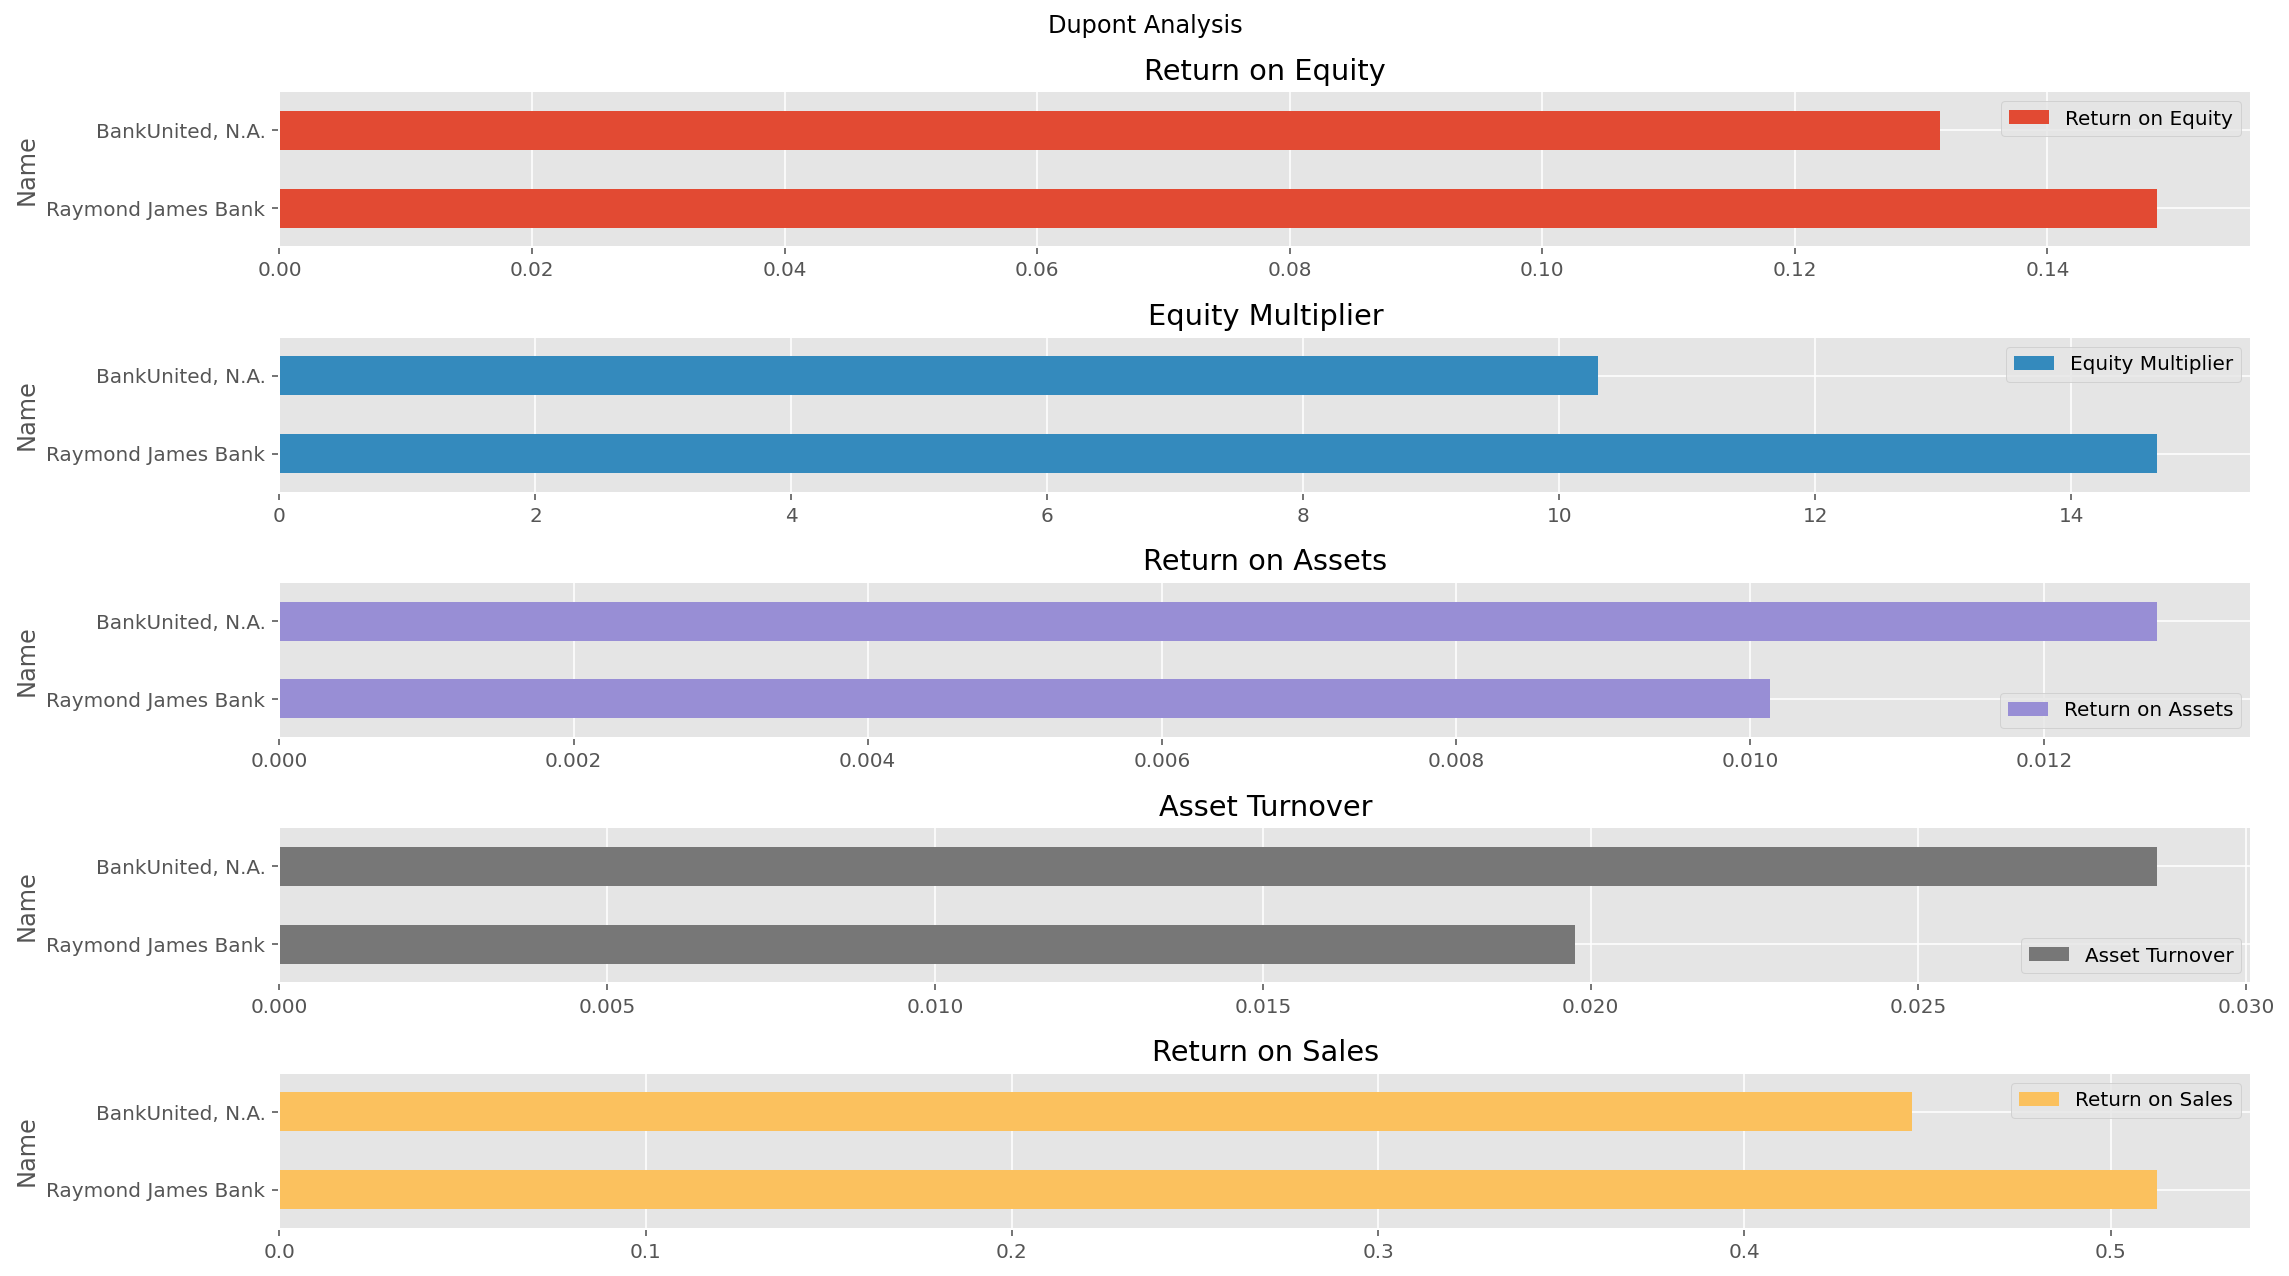

In [18]:
banks_df.T.plot(
    title="Dupont Analysis",
    subplots=True,
    kind="barh",
    figsize=(16, 9),
    sharex=False,
    grid=True,
)
plt.tight_layout()
plt.show()
